# <center> CROP MAPPING WITH SENTINEL-1 and SENTINEL-2 <br><br> Case Study: Hund, Khyaber Pakhtunkhwa, Pakistan - April, 2023 </center> 

# <B>Load Python packages</B>

In [1]:
# MODULE                                                        # DESCRIPTION     
import numpy as np                                              # scientific computing 
import matplotlib as mtp                                        # create visualizations
import matplotlib.pyplot as plt                                 # create visualizations
import pandas as pd                                             # data analysis and manipulation
import geopandas as gpd                                         # extends the datatypes used by pandas to allow spatial operations on geom. types
# import snappy                                                   # SNAP python interface
import earthpy.plot as ep                                       # plot and work with spatial raster and vector data using open source tools 
import rasterio                                                 # Rasterio reads and writes raster formats and provides a Python API based 
from rasterio.plot import reshape_as_raster, reshape_as_image   # on Numpy N-dimensional arrays and GeoJSON

# turns on 'nline plotting', where plot graphics will appear in the notebook below the cell that produced them.
%matplotlib inline              

# Change module setting
pd.options.display.max_colwidth = 80       # Longer text in pd.df

# <B>User input data </B>

The paths to the required input data. Edit the paths to input data

In [2]:
# Path to preprocessed and co-located Sentinel-1 and Sentinel-2 stack
S1_S2_stack = './Training Data/S1_S2_Stack.tif'

# Path to Training and Validation point shapefiles
training_points = './Training Data/Training.shp'
validation_points = './Training Data/Validation.shp'

class_names = ['Tobacco', 'Wheat', 'other vegetation', 'water', 'Concrete', 'bare soil']  # Eight classes represented in our training data.

# <B>Create custom color map </B> 

In this step we will create a custom color for the visualization of our classification results. 

In [3]:
# create a color dictionary with specific colors assigned to specific crop type. 
colors = dict((
    (1, (255,0,0,255)),     # red - Tobacco
    (2, (255,255,0,255)),      # yellow - Wheat
    (3, (0,153,0,255)),      # other vegetation
    (4, (0,76,153,255)),   # blue - Water
    (5, (255,255,255,255)),    # white - Urban
    (6, (255,153,51,255)),      # orange - bare soil
))

# Convert 0 - 255 values to float in range 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v

# Cleate matplotlib colormap from a list of colors and call it Classification   
index_colors = [colors[key] if key in colors else (1, 1, 1, 0) for key in range(1, 7)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 6)

# <B>Load and visualize input data</B>

In [4]:
# Loads the input dataset into a dataset object
src = rasterio.open(S1_S2_stack)

In [5]:
bands = ["B2_M", "B3_M", "B4_M", "B8_M", "B11_M", "B12_M", "Index_NDVI_M", "Index_EVI_M", "Index_GNDVI_M", "Index_BSI_M", "Index_NDWI_M",
        "B2_S0", "B3_S0", "B4_S0", "B8_S0", "B11_S0", "B12_S0", "Index_NDVI_S0", "Index_EVI_S0", "Index_GNDVI_S0", "Index_BSI_S0", "Index_NDWI_S0",
        "B2_S1", "B3_S1", "B4_S1", "B8_S1", "B11_S1", "B12_S1", "Index_NDVI_S1", "Index_EVI_S1", "Index_GNDVI_S1", "Index_BSI_S1", "Index_NDWI_S1",
        "Sigma0_VH_use_local_inci_angle_from_dem_mst_05Apr2023_S2", "Sigma0_VV_use_local_inci_angle_from_dem_mst_05Apr2023_S2",
        "Sigma0_VH_use_local_inci_angle_from_dem_slv1_09Apr2023_S2", "Sigma0_VV_use_local_inci_angle_from_dem_slv2_09Apr2023_S2",
        "Sigma0_VH_use_local_inci_angle_from_dem_slv3_17Apr2023_S2", "Sigma0_VV_use_local_inci_angle_from_dem_slv4_17Apr2023_S2"]

# Visualize a RGB composite of Sentinel-2 image 

(39, 939, 942)


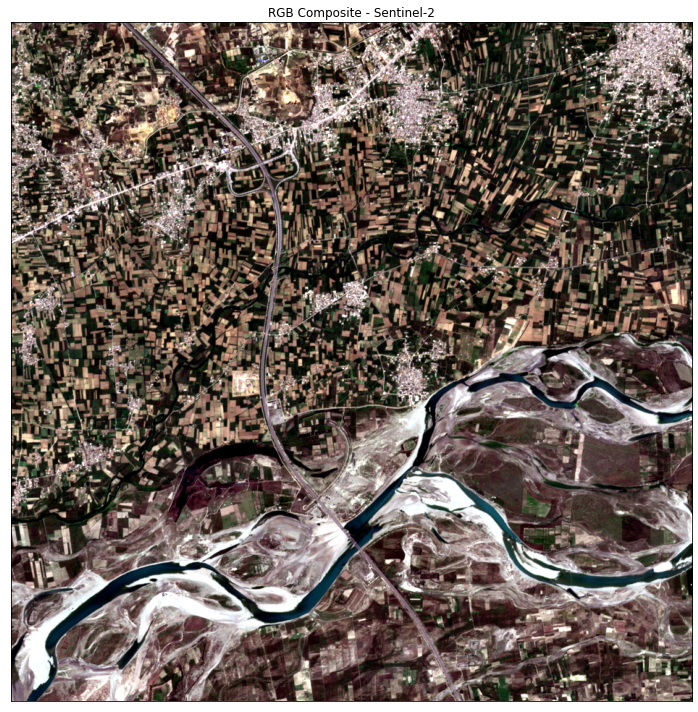

In [6]:
# read all bands of the dataset into 3-dimensional array stack - (band, row, column)
stack = src.read() 
print(stack.shape)
# Create a figure and plot the RGB composites of first Sentinel-2 image (True color) and first Sentinel-1 image (Dual Pol Ratio VV+VH)
# The band numbers must be changed accordingly to your input dataset
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
ax1 = ep.plot_rgb(arr = stack, rgb = (2, 1, 0), stretch=True, ax = ax1, title="RGB Composite - Sentinel-2")
# stack_s1 = np.stack((stack[33], stack[34], stack[34]))  # When using the S1_S2_stack_subset10.tif - the respective bands are 30 and 31 
# ax2 = ep.plot_rgb(arr = stack_s1, rgb = (1, 0, 2), stretch=True, ax = ax2, title="RGB Composite - Sentinel-1 (VV, VH, VV/VH)")
plt.tight_layout()

# <B>4. Create Training/Validation data</B>

In [7]:
# Magic code - this piece if code simply creates an exact copy of our input dataset and saves it in memory file. 
# There should be no reason to do this but this step increases the speed of the trainnig data extraction 
# from 2 hrs without it to 10 sec with creating the copy.
img = src.read()   # load our original input file bands to a numby array stack
profile = src.profile  # the copy the profile of the original GeoTIFF input file
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        for i in range(0, src.count):
            dst.write(img[i], i+1)
    dataset = memfile.open()

# Extract training dataset

In [8]:
# Read points from shapefile
train_pts = gpd.read_file(training_points) 
train_pts = train_pts[['GRIDCODE', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
train_pts.index = range(len(train_pts))
coords = [(x,y) for x, y in zip(train_pts.UTM_E, train_pts.UTM_N)]  # Create list of point coordinates

# Sample the each band of raster dataset at each point in the coordinate list
train_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)  
train_pts = train_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# Change the values for last three classes - original class numbers [0,1,2,3,4,7,8,15] -> [0,1,2,3,4,5,6,7]
# train_pts['GRIDCODE'] = train_pts['GRIDCODE'].replace([7,8,15],[5,6,7]) 
train_pts.to_csv('train_pts.csv') # save our training dataset to CSV
train_pts.head() # visualize the first rows of the dataframe

,GRIDCODE,UTM_E,UTM_N,geometry,B2_M,B3_M,B4_M,B8_M,B11_M,B12_M,...,Index_EVI_S1,Index_GNDVI_S1,Index_BSI_S1,Index_NDWI_S1,Sigma0_VH_use_local_inci_angle_from_dem_mst_05Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_mst_05Apr2023_S2,Sigma0_VH_use_local_inci_angle_from_dem_slv1_09Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_slv2_09Apr2023_S2,Sigma0_VH_use_local_inci_angle_from_dem_slv3_17Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_slv4_17Apr2023_S2
0,1,260129.8943,3766397.933,POINT (260129.894 3766397.933),1894.0,2316.0,2394.0,3702.0,3536.0,3176.0,...,0.155253,0.339297,0.112658,-0.339297,0.011674,0.127214,0.015360,0.079142,0.013733,0.074299
1,1,260142.1175,3766397.444,POINT (260142.118 3766397.445),1922.0,2400.0,2506.0,3428.0,3681.0,3368.0,...,0.138390,0.314966,0.125446,-0.314966,0.012095,0.133564,0.017024,0.099453,0.012086,0.077555
2,1,260125.9829,3766372.509,POINT (260125.983 3766372.509),1840.0,2340.0,2348.0,3636.0,3527.0,3329.0,...,0.136248,0.314506,0.118859,-0.314506,0.011876,0.107816,0.016848,0.069186,0.015450,0.088272
3,1,260133.8057,3766384.732,POINT (260133.806 3766384.732),1922.0,2428.0,2540.0,3654.0,3536.0,3176.0,...,0.132883,0.310655,0.126061,-0.310655,0.011539,0.125529,0.017476,0.082110,0.013610,0.080616
4,1,260146.0290,3766364.197,POINT (260146.029 3766364.197),1940.0,2382.0,2582.0,3442.0,3683.0,3462.0,...,0.132024,0.309677,0.121498,-0.309677,0.012095,0.103187,0.019640,0.083790,0.012678,0.086146


In [9]:
# Check if class numbers were correctly changed
train_pts['GRIDCODE'].unique() 

array([1, 2, 3, 4, 6, 5], dtype=int64)

C:\Users\DELL\AppData\Local\Temp/ipykernel_10880/321218925.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(x) for x in range(1, len(row)+1)])  # Replace column names with numbers


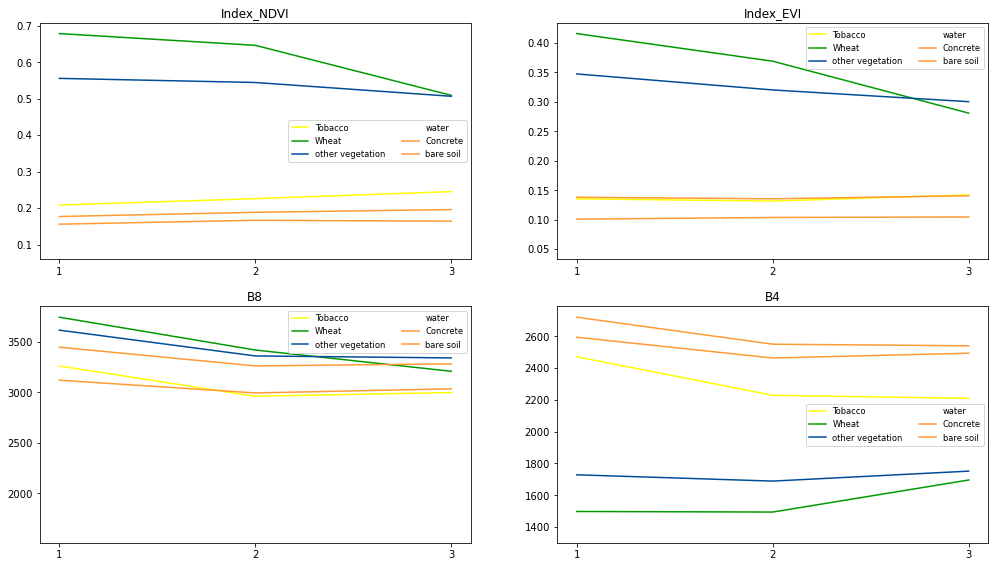

In [10]:
# Plot Class profiles over our dataset (April 2023)
prof = train_pts.groupby(['GRIDCODE']).mean()  #calculate average value for each class in each band
fig = plt.figure(figsize = (17,20)) 
band_n = ['Index_NDVI','Index_EVI','B8','B4'] # bands we included in the analysis for each name we have multiple dates included
n = 1  # counter
for ba in band_n:  # Iterate over band names
    ax = fig.add_subplot(4,2,n) 
    ax.title.set_text(ba)
    band_val = prof[prof.columns[prof.columns.to_series().str.contains(ba)]]  # Select all columns in the dataframe containing a band name e.g. B2
    for index, row in band_val.iterrows():  # Plot line for each class in the selected band
        color = cmap(index)  
        ax.plot(row, color=color) 
    ax.set_xticklabels([str(x) for x in range(1, len(row)+1)])  # Replace column names with numbers
    ax.legend(loc="best", fontsize='small', ncol=2, labels=class_names)
    n = n+1

In [11]:
# Split training dataset to labels (y) and input features (x)
y = train_pts['GRIDCODE'].values  
# We create a different x dataset based on the subset we want to use for training our model
x = []
x.append(train_pts[[b for b in bands if "Sigma0" in b]].values)   # Only Sentinel-1 data
x.append(train_pts[[b for b in bands if (("B" in b) and ("Index" not in b))]].values)  # Only Sentinel-2 data
x.append(train_pts[[b for b in bands if "Index" in b]].values)  # Only Vegetation indices
x.append(train_pts[[b for b in bands if ((("B" in b) or ("Sigma0" in b)) and ("Index" not in b))]].values)  # Only Sentinel-1 and Sentinel-2 data
x.append(train_pts[bands].values)  # all Sentinel-1, Sentinel-2, VI data
del(train_pts, coords)  

In [12]:
# Check the shapes of our feature datasets
print('The trainng data sizes are: Sentinel-1 stack: ', x[0].shape, 
      'Sentinel-2 stack: ', x[1].shape, 'Sentinel-2 VI: ', x[2].shape, 'Sentinel-1 and sentinel 2 bands: ', x[3].shape,
      'Sentinel-1, Sentinel-2 and VI stack: ', x[4].shape)
# print('The trainng data sizes are: ', x[0].shape)

The trainng data sizes are: Sentinel-1 stack:  (1760, 6) Sentinel-2 stack:  (1760, 18) Sentinel-2 VI:  (1760, 15) Sentinel-1 and sentinel 2 bands:  (1760, 24) Sentinel-1, Sentinel-2 and VI stack:  (1760, 39)


# Extract validation dataset

In [13]:
# Read points from shapefile
valid_pts = gpd.read_file(validation_points)
valid_pts = valid_pts[['GRIDCODE', 'UTM_E', 'UTM_N', 'geometry']]  # These are the attributes in our point dataset
valid_pts.index = range(len(valid_pts))
coords = [(x,y) for x, y in zip(valid_pts.UTM_E, valid_pts.UTM_N)]  # Create list of point coordinates
# Sample the each band of raster dataset at each point in the coordinate list
valid_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
valid_pts[bands] = pd.DataFrame(valid_pts['Raster Value'].tolist(), index= valid_pts.index)
valid_pts = valid_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# Change the values for last three classes - original class numbers [0,1,2,3,4,7,8,15] -> [0,1,2,3,4,5,6,7]
# valid_pts['GRIDCODE'] = valid_pts['GRIDCODE'].replace([7,8,15],[5,6,7])
valid_pts.to_csv('valid_pts.csv')   # save our validation dataset to CSV
valid_pts.head()   # visualize the first rows of the dataframe 

,GRIDCODE,UTM_E,UTM_N,geometry,B2_M,B3_M,B4_M,B8_M,B11_M,B12_M,...,Index_EVI_S1,Index_GNDVI_S1,Index_BSI_S1,Index_NDWI_S1,Sigma0_VH_use_local_inci_angle_from_dem_mst_05Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_mst_05Apr2023_S2,Sigma0_VH_use_local_inci_angle_from_dem_slv1_09Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_slv2_09Apr2023_S2,Sigma0_VH_use_local_inci_angle_from_dem_slv3_17Apr2023_S2,Sigma0_VV_use_local_inci_angle_from_dem_slv4_17Apr2023_S2
0,1,260143.5843,3766386.688,POINT (260143.584 3766386.688),1914.0,2344.0,2554.0,3502.0,3681.0,3368.0,...,0.129756,0.306254,0.133950,-0.306254,0.011929,0.127242,0.018457,0.092906,0.012502,0.082009
1,1,260131.3611,3766366.153,POINT (260131.361 3766366.153),1956.0,2478.0,2574.0,3614.0,3527.0,3329.0,...,0.128932,0.306944,0.125497,-0.306944,0.012125,0.099447,0.018028,0.075483,0.014262,0.087534
2,1,260130.6277,3766392.310,POINT (260130.628 3766392.311),1956.0,2466.0,2528.0,3592.0,3536.0,3176.0,...,0.154686,0.330855,0.106621,-0.330855,0.011823,0.134286,0.016394,0.088260,0.012858,0.075852
3,1,260169.7421,3766382.532,POINT (260169.742 3766382.532),1830.0,2222.0,2406.0,3294.0,3530.0,3271.0,...,0.177426,0.355721,0.090335,-0.355721,0.011764,0.125068,0.015410,0.114466,0.011398,0.074723
4,1,260185.3878,3766392.066,POINT (260185.388 3766392.066),1900.0,2298.0,2462.0,3308.0,3481.0,3319.0,...,0.168999,0.338791,0.100667,-0.338791,0.011840,0.110798,0.016847,0.126912,0.011129,0.068577


In [14]:
# Split validation dataset to training and validation data
y_valid = valid_pts['GRIDCODE'].values
# We create a different x dataset based on the subset we want to use for training our model
x_valid = []
x_valid.append(valid_pts[[b for b in bands if "Sigma0" in b]].values)   # Only Sentinel-1 data
x_valid.append(valid_pts[[b for b in bands if (("B" in b) and ("Index" not in b))]].values)  # Only Sentinel-2 data
x_valid.append(valid_pts[[b for b in bands if "Index" in b]].values)  # Only Sentinel-2 data
x_valid.append(valid_pts[[b for b in bands if ((("B" in b) or ("Sigma0" in b)) and ("Index" not in b))]].values)  # Only Sentinel-1 and Sentinel-2 data
x_valid.append(valid_pts[bands].values)  # all Sentinel-1, Sentinel-2 and VI data
del(valid_pts, coords)

In [15]:
# Check the shapes of our feature datasets
print('The validation data sizes are: Sentinel-1 stack: ', x_valid[0].shape, 
      'Sentinel-2 stack: ', x_valid[1].shape, 'Sentinel-2 VI: ', x_valid[2].shape, 'Sentinel-1 and sentinel-2: ', x_valid[3].shape, 
      'Sentinel-1, Sentinel-2, VI stack: ', x_valid[4].shape)
# print('The validation data sizes are: Sentinel-1 stack: ', x_valid[0].shape)

The validation data sizes are: Sentinel-1 stack:  (324, 6) Sentinel-2 stack:  (324, 18) Sentinel-2 VI:  (324, 15) Sentinel-1 and sentinel-2:  (324, 24) Sentinel-1, Sentinel-2, VI stack:  (324, 39)


# Random Forest Classification

Train the RF classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

model_RF = []
for i in range(0, 5):  #  Loop over our three feature datasets and fit a RF model to each
    rf = RandomForestClassifier(n_estimators=500, oob_score=True, max_features='auto')   # Initialize our model with 500 trees and the default parameters
    rf = rf.fit(x[i], y)   # Fit the model to the training dataset
    model_RF.append(rf)  # Save the trained model to a list
rf = None    
# The OOB score of the training dataset obtained using an out-of-bag estimate. 
print('Our OOB prediction of accuracy for S1 stack is: {oob}%'.format(oob=model_RF[0].oob_score_ * 100))
print('Our OOB prediction of accuracy for S2 stack is: {oob}%'.format(oob=model_RF[1].oob_score_ * 100))
print('Our OOB prediction of accuracy for S2 stack (VI) is: {oob}%'.format(oob=model_RF[2].oob_score_ * 100))
print('Our OOB prediction of accuracy for S1 and S2 stack is: {oob}%'.format(oob=model_RF[3].oob_score_ * 100))
print('Our OOB prediction of accuracy for S1, S2 and VI stack is: {oob}%'.format(oob=model_RF[4].oob_score_ * 100))

Our OOB prediction of accuracy for S1 stack is: 72.04545454545455%
Our OOB prediction of accuracy for S2 stack is: 88.06818181818183%
Our OOB prediction of accuracy for S2 stack (VI) is: 82.10227272727273%
Our OOB prediction of accuracy for S1 and S2 stack is: 91.5909090909091%
Our OOB prediction of accuracy for S1, S2 and VI stack is: 92.1590909090909%


# RF Model Validation

In [31]:
from sklearn.metrics import classification_report

label = ['Sentinel-1 only', 'Sentinel-2 only', 'VI stack', 'Sentinel-1 & Sentinel-2 stack', 'Sentinel-1, Sentinel-2 & VI stack']
# Run prediction on the test datastet
for i in range(0, 5):  # Loop over the trained RF models
    rf = model_RF[i]  # Load the trainied model
    y_pred = rf.predict(x_valid[i])  
    print(label[i])
    print(classification_report(y_valid, y_pred, target_names=class_names))  # Print the classification report

Sentinel-1 only
                  precision    recall  f1-score   support

         Tobacco       0.90      0.94      0.92        99
           Wheat       0.90      0.88      0.89        68
other vegetation       0.66      0.85      0.74        60
           water       1.00      0.60      0.75        25
        Concrete       0.81      0.70      0.75        50
       bare soil       0.89      0.77      0.83        22

        accuracy                           0.84       324
       macro avg       0.86      0.79      0.81       324
    weighted avg       0.85      0.84      0.84       324

Sentinel-2 only
                  precision    recall  f1-score   support

         Tobacco       0.97      0.97      0.97        99
           Wheat       0.99      0.99      0.99        68
other vegetation       0.95      0.93      0.94        60
           water       1.00      1.00      1.00        25
        Concrete       0.85      0.88      0.86        50
       bare soil       0.86      0.8

# Classify the image with the trained RF model

In [32]:
# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
# You may need to reduce image size if your kernel crashes, as this step takes a lot of memory
img = dataset.read()  # img = dataset.read()[:, 150:600, 250:1400]
print(img.shape)  # (bands, rows, cols)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)  # (rows, cols, bands)
# Reshape to 2D array
band_num_S1 = [bands.index(l) for l in bands if "Sigma0" in l][0]  # start index for Sentinel-1 bands
band_num_S2 = [bands.index(l) for l in bands if "B" in l][0]       # start index for Sentinel-2 bands
#  Create a reshaped image input for each of our trained models (used also in SVM)
class_input_S1 = reshaped_img[:, :, band_num_S1: band_num_S1 + x[0].shape[1]].reshape(-1, x[0].shape[1])
class_input_S2VI = reshaped_img[:, :, band_num_S2: band_num_S2 + x[1].shape[1] + x[2].shape[1]].reshape(-1, x[1].shape[1] + x[2].shape[1])
class_input_S1S2 = reshaped_img.reshape(-1, x[4].shape[1])
print(class_input_S1S2.shape)  # (rows*cols, bands)

(39, 939, 942)
(939, 942, 39)
(884538, 39)


In [33]:
# Sentinel-1, Sentinel-2 and VI stack classification
rf_S1S2 = model_RF[4]
class_RF_S1S2 = rf_S1S2.predict(class_input_S1S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_RF_S1S2 = class_RF_S1S2.reshape(reshaped_img[:, :, 0].shape)

# Visualize RF results

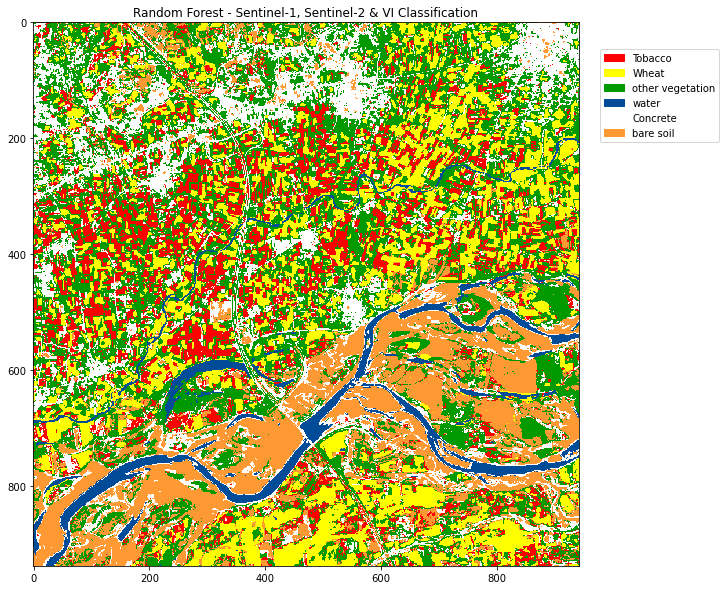

In [34]:
# fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21, 21))
fig, ((ax1)) = plt.subplots(1,1, figsize=(15, 10))
# ax1.set_title('Random Forest - Sentinel-1 Classification')
# im1 = ax1.imshow(class_RF_S1, cmap=cmap, interpolation='none')
# ax2.set_title('Random Forest - Sentinel-2 Classification')
# im2 = ax2.imshow(class_RF_S2, cmap=cmap, interpolation='none')
ax1.set_title('Random Forest - Sentinel-1, Sentinel-2 & VI Classification')
im1 = ax1.imshow(class_RF_S1S2, cmap=cmap, interpolation='none')

# Create a legend with class names and colors
patches = [mtp.patches.Patch(color=cmap(i), label="{:s}".format(class_names[i]) ) for i in range(len(class_names)) ]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(.9, 0.85) )

# Save the classified image from RF

In [35]:
# Save our classification results into a GeoTIFF 
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile
    # change the band count to 3, set the dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8, count=3, compress='lzw')
    with rasterio.open('RF_classification.tif', 'w', **profile) as dst:
#         dst.write(class_RF_S1.astype(rasterio.uint8), 1)
#         dst.write(class_RF_S2.astype(rasterio.uint8), 2)
        dst.write(class_RF_S1S2.astype(rasterio.uint8), indexes=3)

# At the end of the ``with rasterio.Env()`` block, context manager exits and all drivers are de-registered.

# Support Vector Machine (SVM) supervised classification

Train the SVM classifier

In [ ]:
from sklearn import svm

model_SVM = []
for i in range(0, 5):  #  Loop over our three feature datasets and fit a SVM model to each
    svm_ = svm.SVC()  # Initialize our model with the default parameters
    svm_ = svm_.fit(x[i], y)  # Fit the model to the training dataset
    model_SVM.append(svm_)

# SVM Model Validation

In [ ]:
label = ['Sentinel-1 only', 'Sentinel-2 only', 'VI stack', 'Sentinel-1 & Sentinel-2 stack', 'Sentinel-1, Sentinel-2 & VI stack']
# Run prediction on the test datastet
for i in range(0, 5):
    svm = model_SVM[i]
    y_pred_svm = svm.predict(x_valid[i])
    print(label[i])
    print(classification_report(y_valid, y_pred_svm, target_names=class_names))

# Classify the image with the trained SVM model

In [ ]:
# Sentinel-1 and Sentinel-2 stack classification
svm_ = model_SVM[4]
class_SVM_S1S2 = svm_.predict(class_input_S1S2)
# Reshape our classification map back into a 2D matrix so we can visualize it
class_SVM_S1S2 = class_SVM_S1S2.reshape(reshaped_img[:, :, 0].shape)

# Visualize SVM results

In [ ]:
# fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21, 21))
fig, ((ax1)) = plt.subplots(1,1, figsize=(15, 10))
# ax1.set_title('Support Vector Machine - Sentinel-1 Classification')
# im1 = ax1.imshow(class_SVM_S1, cmap=cmap, interpolation='none')
# ax2.set_title('Support Vector Machine - Sentinel-2 Classification')
# im2 = ax2.imshow(class_SVM_S2, cmap=cmap, interpolation='none')
ax1.set_title('Support Vector Machine - Sentinel-1 and Sentinel-2 Classification')
im1 = ax1.imshow(class_SVM_S1S2, cmap=cmap, interpolation='none')

# Create a legend with class names and colors
patches = [mtp.patches.Patch(color=cmap(i), label="{:s}".format(class_names[i]) ) for i in range(len(class_names)) ]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(.9, 0.85) )

# Save the classified image from SVM

In [ ]:
with rasterio.Env():
    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src.profile
    # And then change the band count to 3, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

    with rasterio.open('SVM_classification.tif', 'w', **profile) as dst:
#         dst.write(class_SVM_S1.astype(rasterio.uint8), 1)
#         dst.write(class_SVM_S2.astype(rasterio.uint8), 2)
        dst.write(class_SVM_S1S2.astype(rasterio.uint8), 3)

# At the end of the ``with rasterio.Env()`` block, context
# manager exits and all drivers are de-registered.